# Advertisement in Russian-speaking Instagram - PART I


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import OrderedDict
from io import StringIO
from math import log, sqrt

from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, Div, Select, Slider, TextInput

from bokeh.io import curdoc, show
from bokeh.layouts import widgetbox
import bokeh.plotting.figure as bk_figure


from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler

from collections import OrderedDict
from io import StringIO
from math import log, sqrt
from bokeh.io import output_notebook

from bokeh.plotting import figure, output_file, show

## 1.1 CLEANING  DRAFT  DATASET

In [3]:
file = 'https://raw.githubusercontent.com/ElinaAizenberg/Advertisement-in-Russian-speaking-Instagram---project/main/data/easyprbot.com_reviews_2021_03_05.csv'
table = pd.read_csv(file, header = 0, sep = ';')

In [4]:
table.head()

,ID,Дата рекламы,Мой аккаунт,Брали рекламу у блогера,Цена за подписчика,Приход,Цена за рекламу,Охваты из рекламы,Оценка,Формат рекламы,Темы аккаунта,Текст отзыва
0,59,2019-07-02,masha_davay,chebotareva_e,2.0,4000,10000.0,NaN,10,Сторис,"Жизнь заграницей, Лайфстайл, Мода, стиль и шоп...",Реклама была супер. Весь день в сторис у Элины...
1,61,2019-07-02,since1545,easy__history,0.0,266,200.0,NaN,10,Сторис,"Жизнь заграницей, Лайфстайл, Мода, стиль и шоп...",Она очень ответственно подошла к рекламе из вс...
2,63,2019-07-02,gassanchiki,_anarykova_,7.0,800,6000.0,NaN,5,Сторис,"Жизнь заграницей, Лайфстайл, Мода, стиль и шоп...","Вроде всё неплохо, но\nЗаявленный охват 30-50\..."
3,64,2019-07-02,irene.english.live,vika_portland_film,6.0,300,2000.0,NaN,8,Сторис,"Жизнь заграницей, Лайфстайл, Мода, стиль и шоп...","Вика очень приятная в общении, идет на встречу..."
4,65,2019-07-01,p,markelova.love,1.0,200,300.0,NaN,10,Сторис,"Жизнь заграницей, Лайфстайл, Мода, стиль и шоп...",Шикарный подход к подаче рекламы: блогер вылож...


**Technical steps:**

- delete columns: ID, Client's account name, Date, Comment, Account's topics;

- delete rows where price for ad was 0 RUB, because these were 'mutual PR' cases that are useless for my goal;

- drop rows where format of advertisment was 'Giveaway' because it's very specific case;

- as far as I know results of advertisement might depend on week day and month, therefore I create columns with this information based on Date column;

- drop rows with absent information about prices for ad and ad's statistics because this information is of paramount importance for analysis;

- re-calculate column Price for subscriber because it's manually filled in by reviewers with serious errors;

- get dummy variables for Account's topics column: a reviewer can list unlimited amount of topics in column Account's topic. To make analysis easier I transform this column into multiple dummy variables with 1 or 0 values whether a particular topic was mentioned or not;

- translate column names to English.

In [5]:
# columns: ID, Client's account name
cols = [0,2]

# inplace=True is used to make the changes in the dataframe itself without doing the column dropping on a copy of the data frame.
table.drop(table.columns[cols],axis=1,inplace=True)

# where price for the ad is 0, it means 'mutual PR'. It is also useless for my goal.
table = table[table['Цена за рекламу'] != 0]

#Giveaway is not perconal ad, therefore, not suitable for my model
table = table[table['Формат рекламы'] != 'Гив']

#as far as I know results of an ad depend on week day and month
table['Дата рекламы'] = pd.to_datetime(table['Дата рекламы'], format = '%Y-%m-%d')
table['Month'] = table['Дата рекламы'].dt.month
table['Week day'] = table['Дата рекламы'].dt.weekday

table = table.dropna(subset = ['Цена за рекламу','Охваты из рекламы'])

# The price per subscriber column is terribly calculated (manually by respondents), so, I replace it
# When amount of coming subscribers equals to 0, then the price per subsriber is infinite. To eliminate it, I change the price with the total sum for ad.
table['Цена за подписчика'] = table.apply(lambda row: np.round(row['Цена за рекламу'] / row['Приход'], 2) if row['Приход'] != 0 else row['Цена за рекламу'], axis = 1) 

table = table.reset_index(drop = True)

table = table.rename(columns={'Дата рекламы':'Date', 'Брали рекламу у блогера':'Blogger', 'Цена за подписчика':'Price per subscriber',
       'Приход':'Income', 'Цена за рекламу':'Price per ad', 'Охваты из рекламы':'Ad coverage', 'Оценка':'Rate',
       'Формат рекламы':'Format', 'Темы аккаунта':"Account's topic", 'Текст отзыва':'Comment'}, errors="raise")

In [6]:
table = pd.concat([table,table["Account's topic"].str.get_dummies(sep=', ')],1)

table = table.rename(columns={'Авто':'Auto', 'Бизнес':'Business', 'Бодипозитив':'Body-positivity', 'Бьюти':'Beauty', 'Дом':'Home',
       'Другая тема':'Another topic', 'Животные':'Animals', 'Жизнь заграницей':'Life abroad', 'ЗОЖ':'Healthy lifestyle', 'Здоровье':'Health',
       'Изучение языков':'Languages', 'Книги':'Books', 'ЛГБТ':'LGBT', 'Лайфстайл':'Lifestyle', 'Лайфхаки':'Lifehacks', 'Мамы':'Mothers',
       'Мода':'Fashion', 'Мотивация':'Motivation', 'Музыка':'Music', 'Наука':'Science', 'Нет темы':'No topic', 'Обработка фото':'Photo Retouching',
       'Образование':'Education', 'Отношения':'Relationships', 'ПП':'Right nutrition', 'Похудение':'Diets', 'Природа и экология':'Ecology',
       'Продуктивность':'Productivity', 'Профессии (юрист':'Lawyer', 'Психология':'Psychology', 'Путешествия':'Travelling',
       'Ремонт и интерьер':'Design and decor', 'Рецепты и еда':'Food', 'Рукоделие':'Handicraft', 'СММ':'SMM',
       'Сад и огород':'Garden', 'Саморазвитие':'Self-development', 'Секс':'Sex', 'Семья':'Family', 'Социальные темы':'Social topics',
       'Спорт и фитнес':'Sport', 'Танцы':'Dancing', 'Творчество и искусство':'Art', 'Феминизм':'Feminism',
       'Фильмы':'Movies', 'Эзотерика':'Esotericism', 'Юмор':'Humor', 'дизайнер и т.д.)':'Designer', 'интерьер и ремонт':'Renovation',
       'реклама и пиар':'PR', 'стиль и шоппинг':'Shopping and style'})

cols = [0,8,9]
table.drop(table.columns[cols],axis=1,inplace=True)
table.head()

,Blogger,Price per subscriber,Income,Price per ad,Ad coverage,Rate,Format,Month,Week day,Auto,...,Dancing,Art,Feminism,Movies,Esotericism,Humor,Designer,Renovation,PR,Shopping and style
0,ella.mom,5.99,334,2000.0,7115.0,8,Сторис,7,3,0,...,0,0,0,0,0,0,0,0,0,1
1,alenafedorova,50.85,118,6000.0,20151.0,6,Сторис,7,1,0,...,0,0,0,0,0,0,0,0,0,1
2,innagrinyuk,19.61,102,2000.0,10400.0,6,Сторис,7,0,0,...,0,0,0,0,0,0,0,0,0,1
3,alborovaas,63.06,111,7000.0,22900.0,6,Сторис,7,1,0,...,0,0,0,0,0,0,0,0,0,1
4,mamalapatundelya,18.29,82,1500.0,6077.0,7,Сторис,7,3,0,...,0,0,0,0,0,0,0,0,0,1


**Columns:**

- *Blogger:* account name of blogger-executor, so, the one who provided ad placement in his/her blog;

- *Price per subscriber (in RUB):* shows how much every subscriber costed for blogger-client;

- *Income:* amount of subscribers came after advertisement;

- *Price per ad (in RUB):* shows how much ad placement costed;

- *Ad coverage:* who many viewers saw this advertisement;

- *Rate (from 1 to 10):* the rate that client gave to blogger for ad results and for the whole ordering process;

- *Format:* there are 4 ad formats: Stories, Post + Stories, Photo-post, Video-post;

- *Account's topic (Auto, Dancing, Art etc.):* topics of client's blog that were disclosed or advertised.

## 1.2 DISTRIBUTION  OF  PRICES

One of the main metrics to evaluate succes of an advertisemnt is price for subscriber. If bloggers can approximetely figure average price for subscriber, thus they can plan budget for advertisement according to their goals.

As you can see below, in both cases, price for subscriber and for advertisement, distributions are unimodal, asymmetrical and right-skewed with very long right tail.

Due to impressive and unusual cases, when the ad placement costed 220 000 RUB (appr. 2825 USD) which is maximum value in Price per ad column, or when the advertisement was obviously extremely unsuccesseful with price per subscriber of 8 500 RUB (appr. 109 USD), I decided to use 97% - percentile to eliminate the influence of anomalies.

**So, the presented plots show metrics for 97% of the filtered data.**

In [8]:
print('Summary statistics for original dataset and 97% percentile')

summary = pd.DataFrame()
summary = table[['Price per subscriber','Price per ad']].describe()

summary['Price per subscriber (97% perc.)'] = table[table['Price per subscriber'] <= table['Price per subscriber'].quantile(.97)]['Price per subscriber'].describe()
summary['Price per ad (97% perc.)'] = table[table['Price per ad'] <= table['Price per ad'].quantile(.97)]['Price per ad'].describe()
summary


Summary statistics for original dataset and 97% percentile


,Price per subscriber,Price per ad,Price per subscriber (97% perc.),Price per ad (97% perc.)
count,24303.000000,24303.000000,23573.000000,23590.000000
mean,10.752408,4134.816854,6.373957,2946.033616
std,87.059686,9231.141589,5.247217,3770.671831
min,0.000000,1.000000,0.000000,1.000000
25%,3.080000,700.000000,3.000000,700.000000
50%,5.050000,1500.000000,5.000000,1500.000000
75%,8.330000,4000.000000,7.890000,3500.000000
max,8500.000000,220000.000000,37.040000,23000.000000


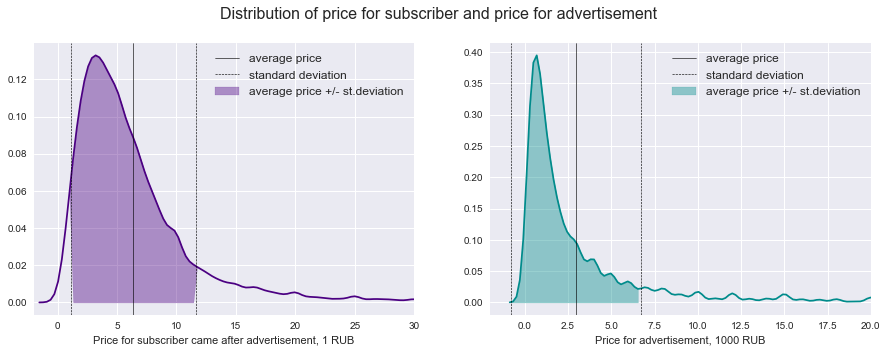

In [9]:
"----------------data preprocessing-----------------------------"

price_per_sub = table[table['Price per subscriber'] <= table['Price per subscriber'].quantile(.97)]['Price per subscriber']
price_per_ad = table[table['Price per ad'] <= table['Price per ad'].quantile(.97)]['Price per ad'] / 1000

"----------------creating plots-----------------------------"

fig = plt.figure(figsize = (15,5))
plt.style.use('seaborn')
fig.suptitle('Distribution of price for subscriber and price for advertisement', fontsize=16)

spec = fig.add_gridspec(1, 2)
f_ax1 = fig.add_subplot(spec[0, 0])
f_ax2 = fig.add_subplot(spec[0, 1])


"----------------price per subscriber plot-----------------------------"

ax = sns.distplot(price_per_sub, hist=False, ax = f_ax1, color = 'indigo')
f_ax1.axvline(price_per_sub.mean(), linestyle="-", color="black", linewidth = 0.6, label = 'average price')

x0 = price_per_sub.mean() + price_per_sub.std()
x1 = price_per_sub.mean() - price_per_sub.std()

f_ax1.axvline(x0, linestyle="--", color="black", linewidth = 0.6, label = 'standard deviation')
f_ax1.axvline(x1, linestyle="--", color="black", linewidth = 0.6)

kde_x, kde_y = ax.lines[0].get_data()
f_ax1.fill_between(kde_x, kde_y, where=(kde_x>=x1) & (kde_x<=x0) , 
                interpolate=True, color='indigo', alpha = 0.4, label = 'average price +/- st.deviation')

f_ax1.set_xlabel('Price for subscriber came after advertisement, 1 RUB')
f_ax1.set_xlim(-2, 30)
f_ax1.legend(loc = 'upper right', fontsize = 12) 

"----------------price per ad plot-----------------------------"

ax2 = sns.distplot(price_per_ad, hist=False, ax = f_ax2, color = 'darkcyan')
f_ax2.axvline(price_per_ad.mean(), linestyle="-", color="black", linewidth = 0.6, label = 'average price')

x2 = price_per_ad.mean() + price_per_ad.std()
x3 = price_per_ad.mean() - price_per_ad.std()

f_ax2.axvline(x2, linestyle="--", color="black", linewidth = 0.6, label = 'standard deviation')
f_ax2.axvline(x3, linestyle="--", color="black", linewidth = 0.6)

kde_x2, kde_y2 = ax2.lines[0].get_data()
f_ax2.fill_between(kde_x2, kde_y2, where=(kde_x2>=x3) & (kde_x2<=x2) , 
                interpolate=True, color='darkcyan', alpha = 0.4, label = 'average price +/- st.deviation')

f_ax2.set_xlabel('Price for advertisement, 1000 RUB')
f_ax2.set_xlim(-2, 20)
f_ax2.legend(loc = 'upper right', fontsize = 12) 


fig.align_labels()

plt.show()


**Key insights:**

- average price per subscriber is 6-7 RUB, so, if my goal is 1500 - 2000 subscribers, I should manage my budget for advertisement around 10 000 - 14 000 RUB. My prior estimation was quite close. Considering the fact that several years ago fair price per subscriber was discussed to be 10 RUB, I presume that quality and efficiency of advertisement increased;

- average price for advertisement is lower than I expected based on my previous experience - around 3 000 RUB (I expected it to be higher). More expensive ads over 10 000 RUB are quite rare;

- the most frequent price for ad is 1000 RUB, so, I assume that the majiority of bloggers who order ad placement have small budgets for advertisement and prefer to apply for advertisement in small-size blogs;

- it seems reasonable to order several advertisements for various prices in range of 1000 - 5000 RUB.

## 1.3 ADVERTISEMENT  PER  MONTH  AND  DAY  OF  WEEK

**Assumptions before analysis:**


- there are fewer advertisements on weekends, because people tend to spend less time in Instagram and bloggers have less views of posts and stories;

- during cold months people spend more time at home and, therefore, in Instagram. Bloggers use it for advertisement;

- there is no correlation between prices and month or week day of advertisement.

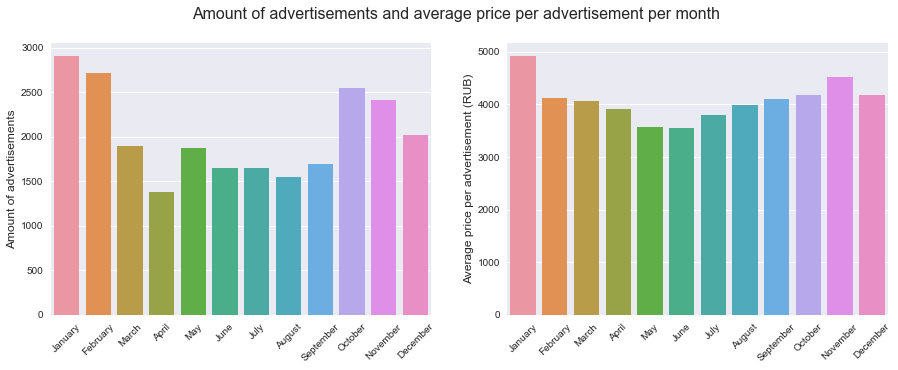

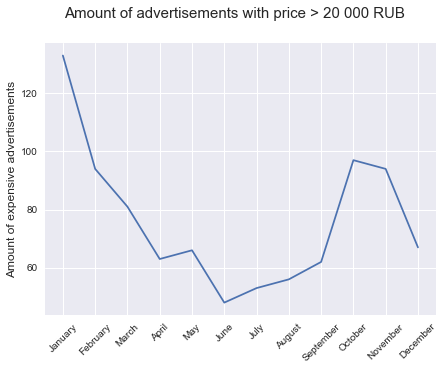

In [10]:
"----------------data preprocessing-----------------------------"

y = table.groupby(by = 'Month')['Price per ad'].mean()
y_1 = table[table['Price per ad'] >= 20000].groupby(by = 'Month')['Price per ad'].count()

"----------------creating plots-----------------------------"

fig2 = plt.figure(figsize = (15,5))
plt.style.use('seaborn')
fig2.suptitle('Amount of advertisements and average price per advertisement per month', fontsize=16)

fig2_1 = plt.figure(figsize = (7,5))
fig2_1.suptitle('Amount of advertisements with price > 20 000 RUB', fontsize=15)

spec = fig2.add_gridspec(1, 2)
f2_ax1 = fig2.add_subplot(spec[0, 0])
f2_ax2 = fig2.add_subplot(spec[0, 1])

fig2_1_ax = fig2_1.add_subplot()


sns.countplot(x = 'Month', data = table, ax = f2_ax1)
sns.barplot(y.index, y, ax = f2_ax2)
sns.lineplot(y_1.index, y_1, ax = fig2_1_ax)

f2_ax1.set_xticklabels(['January','February','March', 'April','May','June','July', 'August', 'September', 'October', 'November','December'], rotation = 45)
f2_ax1.set_ylabel('Amount of advertisements', fontsize = 12)
f2_ax1.set_xlabel('')

f2_ax2.set_xticklabels(['January','February','March', 'April','May','June','July', 'August', 'September', 'October', 'November','December'], rotation = 45)
f2_ax2.set_ylabel('Average price per advertisement (RUB)', fontsize = 12)
f2_ax2.set_xlabel('')

fig2_1_ax.set(xticks=y_1.index)
fig2_1_ax.set_xticklabels(['January','February','March', 'April','May','June','July', 'August', 'September', 'October', 'November','December'], rotation = 45)
fig2_1_ax.set_ylabel('Amount of expensive advertisements', fontsize = 12)
fig2_1_ax.set_xlabel('')


fig.align_labels()

plt.show()

**Key insights:**

- amount of advertisemnts obviously depends on season of the year. You can notice that the maximum is achieved in January. I assume it could be linked with long state holidays in Russia after New Year as well as freezing and raw weather. If bloggers have higher number of viewes, they can sell more ad placements during these periods;

- significant drop in amount of ads from almost 3000 per month to average of 1600 ads during spring and summer months indicates decline in interest of both subscribers and bloggers-clients;

- I presume that surge in amount in Ocotber/November is closely related to upcoming holidays (New Year/Christmas). So, if bloggers deal with goods/services advertised as holiday presents, it might be a high season for them;

- although you can notice reduction in average price from almost 5000 RUB to approximately 3500 RUB in May and June, I strongly believe that this tendency is linked to amount of expensive advertisements and doesn't indicate real fluctuations in prices. As you can see on the 3rd plot, two peaks in January and October repeate increases on the 2nd plot;

- based on my personal observations, if there are too many ads on daily basis, people get fed up with them. Therefore, I prefer to order advertisement during less active and competitive periods, like in April or June. There is no seasonality in my blog and I do not need to follow seasonal trends.

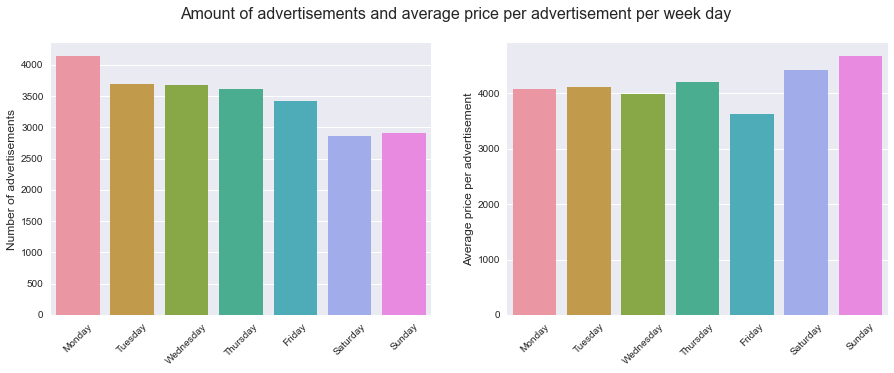

In [11]:
y_2 = table.groupby(by = 'Week day')['Price per ad'].mean()

"----------------creating plots-----------------------------"

fig3 = plt.figure(figsize = (15,5))
plt.style.use('seaborn')
fig3.suptitle('Amount of advertisements and average price per advertisement per week day', fontsize=16)

spec = fig3.add_gridspec(1, 2)
f3_ax1 = fig3.add_subplot(spec[0, 0])
f3_ax2 = fig3.add_subplot(spec[0, 1])

sns.countplot(x = 'Week day', data = table, ax = f3_ax1)
sns.barplot(y_2.index, y_2, ax = f3_ax2)

f3_ax1.set_xticklabels(['Monday','Tuesday','Wednesday', 'Thursday','Friday','Saturday','Sunday'], rotation = 45)
f3_ax1.set_ylabel('Number of advertisements', fontsize = 12)
f3_ax1.set_xlabel('')

f3_ax2.set_xticklabels(['Monday','Tuesday','Wednesday', 'Thursday','Friday','Saturday','Sunday'], rotation = 45)
f3_ax2.set_ylabel('Average price per advertisement', fontsize = 12)
f3_ax2.set_xlabel('')


fig3.align_labels()

plt.show()

**Key insights:**
- maximum amount of advertisement is shown on Monday and minimum on weekend. Personally, I prefer to stick to the plan of advertising in less intense periods, so, I would prefer to choose Thursday or Friday. From my experience of office work people might spend more time in social networks by the end of friday;
- surprisingly, there is some fluctuations in average price in the end of week. I suppose there is an explanation that involves amount of expensive advertisemnts and higher rates on weekend, but nothing reasonable and logic comes to my mind. 

## 1.4 PRICES  FOR  ADVERTISEMENT  PER  FORMAT  AND PER  TOPIC

**Topic is essential variabe for client and not for executor**

Filling the review form on the [website](https://easyprbot.com/#/reviews), bloggers indicate thier topics: food, sport, relationships etc. *Why is it important to state client's topics, not executor's topics?*

Because the review shows whether this or that topic is interesting for audience of blogger-executor. For instance, in blog about feminism advertisement of blogger who tells about financial independence, investments, careers will highly likely be successful. But advertisement of diets and recipes in the same blog will probably fail.

Blogger-executor can change majior topics of its blog inline with life circumstances and current interests. So, in different periods different clients' blogs can 'work out'.

Nevertheless, it seems that bloggers prefer to order ad placement in more or less similar segment of Instagram as their own blogs. Therefore, it is possible to analyse median costs to develop blog with a certain topic.

**Room for improvement**

What could make analysis more effecient is comparison of results between situations when blogs' topics of client and executor are 100% similar, partially similar or absolutely different. Unfortunately, information of executor's topics is not provided on the website.

**Advertisement formats**

There are 4 formats of personal advertisemnt in Instagram:
1. Stories;
2. Post + Stories;
3. Photo-post;
4. Video-post.

Several years ago photo-post was a dominant formart for advertisement because stories just appeared and their views' statistics were much worse than amount of posts' viewers. Therefore, the price for advertisement in stories was tangibly lower.

Recently stories became more popular and more efficient in terms of advertising other blogs. Subsequently, prices have changed.  

**Technical steps:**
1. group all reviews by topics, sort and filter the most frequent topics (18 out of 51);
2. combine several similar topics together, for example, Healthy lifestyle +  Health, Relationships + Family etc.;
3. calculate median prices per topic/per format of advertisement.

In [12]:
table[['Auto', 'Business', 'Body-positivity', 'Beauty', 'Home',
       'Another topic', 'Animals', 'Life abroad', 'Healthy lifestyle',
       'Health', 'Languages', 'Books', 'LGBT', 'Lifestyle', 'Lifehacks',
       'Mothers', 'Fashion', 'Motivation', 'Music', 'Science', 'No topic',
       'Photo Retouching', 'Education', 'Relationships', 'Right nutrition',
       'Diets', 'Ecology', 'Productivity', 'Lawyer', 'Psychology',
       'Travelling', 'Design and decor', 'Food', 'Handicraft', 'SMM', 'Garden',
       'Self-development', 'Sex', 'Family', 'Social topics', 'Sport',
       'Dancing', 'Art', 'Feminism', 'Movies', 'Esotericism', 'Humor',
       'Designer', 'Renovation', 'PR', 'Shopping and style']].sum().sort_values(ascending = False)[0:18]

"----------------data preprocessing-----------------------------"

formats = table.Format.unique()
topics = ['Beauty', 'Healthy lifestyle', 'Health', 'Lifestyle', 'Mothers', 'Life abroad',
       'Motivation', 'Relationships', 'Right nutrition', 'Diets','Psychology', 'Travelling',
       'Food', 'Self-development', 'Sex', 'Family','Sport']

burtin_table = pd.DataFrame(columns = topics, index = formats)



for format in formats:
    burtin_table.loc[format, 'Beauty'] = table.loc[(table['Format'] == format) & (table['Beauty'] == 1)]['Price per ad'].median()
    burtin_table.loc[format, 'Health'] = table.loc[((table['Format'] == format) & (table['Healthy lifestyle'] == 1)) | ((table['Format'] == format) & (table['Health'] == 1))]['Price per ad'].median()
    burtin_table.loc[format, 'Lifestyle'] = table.loc[(table['Format'] == format) & (table['Lifestyle'] == 1)]['Price per ad'].median()
    burtin_table.loc[format, 'Mothers'] = table.loc[(table['Format'] == format) & (table['Mothers'] == 1)]['Price per ad'].median()
    burtin_table.loc[format, 'Psychology'] = table.loc[(table['Format'] == format) & (table['Psychology'] == 1)]['Price per ad'].median()    
    burtin_table.loc[format, 'Travelling'] = table.loc[((table['Format'] == format) & (table['Life abroad'] == 1)) | ((table['Format'] == format) & (table['Travelling'] == 1))]['Price per ad'].median()    
    burtin_table.loc[format, 'Relationships'] = table.loc[((table['Format'] == format) & (table['Relationships'] == 1)) | ((table['Format'] == format) & (table['Family'] == 1))]['Price per ad'].median()
    burtin_table.loc[format, 'Sport'] = table.loc[((table['Format'] == format) & (table['Sport'] == 1)) | ((table['Format'] == format) & (table['Diets'] == 1))]['Price per ad'].median()
    burtin_table.loc[format, 'Food'] = table.loc[((table['Format'] == format) & (table['Right nutrition'] == 1)) | ((table['Format'] == format) & (table['Food'] == 1))]['Price per ad'].median()
    burtin_table.loc[format, 'Motivation'] = table.loc[(table['Format'] == format) & (table['Motivation'] == 1)]['Price per ad'].median()
    burtin_table.loc[format, 'Sex'] = table.loc[(table['Format'] == format) & (table['Sex'] == 1)]['Price per ad'].median()
    burtin_table.loc[format, 'Self-development'] = table.loc[(table['Format'] == format) & (table['Self-development'] == 1)]['Price per ad'].median()
    
burtin_table = burtin_table.transpose().dropna()
burtin_table.reset_index(level=0, inplace=True)     

In [13]:
burtin_table['Сторис'] = burtin_table['Сторис'].astype(float, errors = 'raise')
burtin_table['Пост + сторис'] = burtin_table['Пост + сторис'].astype(float, errors = 'raise')
burtin_table['Видео-пост'] = burtin_table['Видео-пост'].astype(float, errors = 'raise')
burtin_table['Фото-пост'] = burtin_table['Фото-пост'].astype(float, errors = 'raise')
burtin_table = burtin_table.rename(columns={"index": "topic","Сторис": "Stories","Пост + сторис": "Post + stories","Видео-пост": "Video-post","Фото-пост": "Photo-post" })
burtin_table

,topic,Stories,Post + stories,Video-post,Photo-post
0,Beauty,1500.0,1800.0,700.0,700.0
1,Health,1500.0,1600.0,1200.0,675.0
2,Lifestyle,1500.0,1800.0,650.0,875.0
3,Mothers,1500.0,1550.0,650.0,800.0
4,Motivation,1500.0,2150.0,800.0,800.0
5,Relationships,1500.0,1400.0,600.0,800.0
6,Psychology,1500.0,1500.0,750.0,800.0
7,Travelling,1500.0,1800.0,600.0,800.0
8,Food,1500.0,2000.0,925.0,900.0
9,Self-development,1500.0,2500.0,600.0,1400.0


In [14]:

output_notebook()

format_color = OrderedDict([
    ("Stories",   "#782B9D"),
    ("Post + stories", "#EA4F88"),
    ("Photo-post",     "#F98477"  ),
    ("Video-post", "#F1C18E"),
])


width = 800
height = 800
inner_radius = 90
outer_radius = 300 - 10

minr = 0
maxr = 5

a = (inner_radius - outer_radius) / (minr - maxr)
b = outer_radius - a * maxr

def rad(mic):
    return a*mic/500+b


big_angle = 2.0 * np.pi / (len(burtin_table) + 1)
small_angle = big_angle / 9

p = figure(plot_width=width, plot_height=height, title="",
    x_axis_type=None, y_axis_type=None,
    x_range=(-420, 420), y_range=(-420, 420),
    min_border=0, outline_line_color="black",
    background_fill_color="#fff5d9")

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

# annular wedges
angles = np.pi/2 - big_angle/2 - burtin_table.index.to_series()*big_angle

series = pd.Series(np.arange(0,13))
angles_axis = np.pi/2 - big_angle/2 - series*big_angle

p.annular_wedge(
    0, 0, inner_radius, outer_radius, -big_angle+angles, angles, color='#c0c0cc',
)

# small wedges
p.annular_wedge(0, 0, inner_radius, rad(burtin_table['Stories']),
                -big_angle+angles+7*small_angle, -big_angle+angles+8*small_angle,
                color=format_color['Stories'])
p.annular_wedge(0, 0, inner_radius, rad(burtin_table['Post + stories']),
                -big_angle+angles+5*small_angle, -big_angle+angles+6*small_angle,
                color=format_color['Post + stories'])
p.annular_wedge(0, 0, inner_radius, rad(burtin_table['Photo-post']),
                -big_angle+angles+3*small_angle, -big_angle+angles+4*small_angle,
                color=format_color['Photo-post'])
p.annular_wedge(0, 0, inner_radius, rad(burtin_table['Video-post']),
                -big_angle+angles+1*small_angle, -big_angle+angles+2*small_angle,
                color=format_color['Video-post'])

# circular axes and lables
labels = 500*np.arange(0,6)
radii = a*labels/500+b
p.circle(0, 0, radius=radii, fill_color=None, line_color="white")
p.text(0, radii[:6], [str(r) for r in labels],
       text_font_size="11px", text_align="center", text_baseline="middle")

# radial axes
p.annular_wedge(0, 0, inner_radius-10, outer_radius+10,
                -big_angle+angles_axis, -big_angle+angles_axis, color="black")

# topics labels
xr = radii[5]*np.cos(np.array(-big_angle/2 + angles))
yr = radii[5]*np.sin(np.array(-big_angle/2 + angles))
label_angle=np.array(-big_angle/2+angles)
label_angle[label_angle < -np.pi/2] += np.pi # easier to read labels on the left side
p.text(xr, yr, burtin_table['topic'], angle=label_angle,
       text_font_size="12px", text_align="center", text_baseline="middle")

# OK
p.rect([-40, -40, -40, -40], [27, 9, -9, -27], width=30, height=13,
       color=list(format_color.values()))
p.text([-15, -15, -15, -15], [27, 9, -9, -27], text=list(format_color),
       text_font_size="12px", text_align="left", text_baseline="middle")

show(p)


Loading BokehJS ...

**Key insights:**

- median prices in different topics can differ, and also price tendencies inside topics can vary. For instance, in almost all topics the most expensice format is Post + stories which is obvious. But in Sex and Relationships Stories format seems to be the most expensive. In Psychology segment median prices for Stories and Post + stories formats are equal;

- previously I was convinsed that video format of advertisemnt should be more expensive than stories or photo-post, because it's generally more time-consuming and technically more complicated to create. Despite this in almost all popular segments we can observe that photo-posts more or less overcome video-posts in median prices. I presume it's linked to the fact that photo-posts are more clickable and usually video-posts gather less likes;

- 3 most expensive segments out of presented ones are Self-development, Motivation and Food;

- stable median price for Stories format across these topics is 1500 RUB and only one outlier topic is Sex with 1700 RUB for advertisement in Stories;

- 2 of the presented topics suit for my blog: self-development and travelling. Considering my budget, I would probably choose Post + stories for Travelling (700 RUB cheaper) and Stories for both Self-development and Travelling (equal price).

## 1.5 INSTRUMENT  TO  SEARCH  FOR  AD  PLACEMENT

Now we can plan when to order advertisement, approximate budget for certain amount of new subscribers, what topics to choose for blog presentation and what formats and cheaper for corresponding topics.

__*But how to choose suitable blogs for ad placement among thousands of blogs?*__

I hope this interactive scatter plot will facilitate and accelearte the process.

For instance, I need to find several bloggers to advertise my blog:

- topics: Travelling, Self-development, Books, Science;
- price range for Stories: 1500 - 1700;
- price range for Post + stories: 1800 - 3000;
- minimum blogger's rate: 8;
- minimum amount of new subscribers: price / 6.5 RUB, because it's an average price per subscriber.

Obviously, not every blogger I choose has available slot for me in suitable time periods. Successfull advertisemnt for another client doesn't automatically mean great result for my blog. Even though the dataset is quite fresh, selected blogers might increase prices. Therefore, I have to filter at least 5 bloggers per topic. Let's start with Travelling.


In [15]:
output_notebook()

sc_table = table.copy()

color_dict = {'Сторис' : 'darkcyan', 'Пост + сторис':'indigo', 'Видео-пост':'#F1C18E', 'Фото-пост':'#EA4F88'}
sc_table["color"] = sc_table["Format"].map(color_dict)

axis_map = {
    "Amount of subscribers came after ad": "Income",
    "Price per advertisement": "Price per ad",
    "Number of ad viewers": "Ad coverage"}

# Create Input controls
subscribers = Slider(title="Minimum amount of subscribers", value=100, start=0, end=7000, step=100) #97% percentile - max
min_price = Slider(title="Minimum price per advertisement", start=1, end=20000, value=1000, step=200)
max_price = Slider(title="Maximum price per advertisement", start=3000, end=220000, value=5000, step=200)
viewers = Slider(title="Minimum number of advertisement viewers", start=0, end=200000, value=1000, step=1000)
rate = Slider(title="Minimum blogger's rate", start=0, end=10, value=0, step=1)

acc_topic = ['All','Auto', 'Business', 'Body-positivity', 'Beauty', 'Home',
       'Another topic', 'Animals', 'Life abroad', 'Healthy lifestyle',
       'Health', 'Languages', 'Books', 'LGBT', 'Lifestyle', 'Lifehacks',
       'Mothers', 'Fashion', 'Motivation', 'Music', 'Science', 'No topic',
       'Photo Retouching', 'Education', 'Relationships', 'Right nutrition',
       'Diets', 'Ecology', 'Productivity', 'Lawyer', 'Psychology',
       'Travelling', 'Design and decor', 'Food', 'Handicraft', 'SMM', 'Garden',
       'Self-development', 'Sex', 'Family', 'Social topics', 'Sport',
       'Dancing', 'Art', 'Feminism', 'Movies', 'Esotericism', 'Humor',
       'Designer', 'Renovation', 'PR', 'Shopping and style']

ad_format = ['All','Сторис','Пост + сторис', 'Видео-пост', 'Фото-пост']

topic = Select(title="Client's blog topic", value="All", options = acc_topic)
ad_form = Select(title="Format of advertisement", value="All", options = ad_format)

comment = TextInput(title="Comment contains")

x_axis = Select(title="X Axis", options=sorted(axis_map.keys()), value="Number of ad viewers")
y_axis = Select(title="Y Axis", options=sorted(axis_map.keys()), value="Amount of subscribers came after ad")

# Create Column Data Source that will be used by the plot
source = ColumnDataSource(data=dict(x=[], y=[], color=[], blogger=[], price=[], subscribers=[]))

TOOLTIPS=[
    ("Blogger", "@blogger"),
    ("Price", "@price rubles"),
    ("Amount of sub.", "@subscribers subscribers came")
]

p = bk_figure(plot_height=600, plot_width=700, title="", tools="crosshair,pan,reset,save,wheel_zoom", sizing_mode="scale_both")
p.circle(x="x", y="y", source=source, size=7, color="color", alpha=0.5, line_color=None)

from bokeh.models import HoverTool

hover = HoverTool()

hover.tooltips = TOOLTIPS
p.tools.append(hover)

def select_bloggers():
    topic_val = topic.value
    form_val = ad_form.value
    selected = sc_table[
        (sc_table['Income'] >= subscribers.value) &
        (sc_table['Ad coverage'] >= viewers.value) &
        (sc_table['Price per ad'] >= min_price.value) &
        (sc_table['Price per ad'] <= max_price.value) &
        (sc_table['Rate'] >= rate.value)
    ]
    if (topic_val != "All"):
        selected = selected[selected[topic_val] == 1]
    if (form_val != "All"):
        selected = selected[selected.Format == form_val]
        #selected = selected[selected.Format.str.contains(form_val)==True]
        
    return selected

def update():
    df = select_bloggers()
    x_name = axis_map[x_axis.value]
    y_name = axis_map[y_axis.value]

    p.xaxis.axis_label = x_axis.value
    p.yaxis.axis_label = y_axis.value
    p.title.text = "%d bloggers selected" % len(df)
    source.data = dict(
        x=df[x_name],
        y=df[y_name],
        color=df["color"],
        blogger=df["Blogger"],
        price=df["Price per ad"],
        subscribers=df["Income"],
    )
    
controls = [subscribers, min_price, max_price, viewers, rate, topic, ad_form, x_axis, y_axis]
for control in controls:
    control.on_change('value', lambda attr, old, new: update())

# Set up layouts and add to document
inputs = column(subscribers, min_price, max_price, viewers, rate, topic, ad_form, x_axis, y_axis)
layout = row(p, column(subscribers, min_price, max_price, viewers, rate, topic, ad_form, x_axis, y_axis))

def modify_doc(doc):
    doc.add_root(row(layout, width=800))


handler = FunctionHandler(modify_doc)
app = Application(handler)

show(app)




Loading BokehJS ...

1. In Travelling format Post + Stories is not wide-spread and with my settings there are only 4 options. I choose @recept_elena (900 subscribers for 2500 RUB).
2. Format Stories is much more popular, so, I choose 4 most effective ads: 
  - @ulyana.verner (1400 subscribers for 1495 RUB);
  - @kotodonn(1032 subscribers for 1500 RUB);
  - @zoynka (900 subscribers for 1500 RUB);
  - @dr_sorkin (777 subscribers for 1700 RUB).
  
*Speaking about last blog, I would never guess to advertise travel-blog in professional blog of proctologist*.